# MDD

### Author: M.Ravasi

This notebook performs Multi-dimensional deconvolution (MDD) on the retrived 3D Green's functions to produce a local target reflectivity response $R$

In this context MDD can be written as

$$\mathbf{g^-}= \mathbf{G^+} \mathbf{R}$$

where $\mathbf{G^+}$ is the MDC operator created using the retrieved downgoing GF's while $\mathbf{g^+}$ is our data that contains the retrieved upgoing GF's. Both set of GF's can be computed upfront by running the ``Marchenko3D.sh`` script.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import pylops
import pylops_distributed

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from dask.distributed import Scheduler, Client

from dask_jobqueue import PBSCluster
from dask.distributed import Client

from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *

from pylops.utils import dottest
from pylops_distributed.utils import dottest as ddottest
from pylops_distributed.optimization.cg import cg as dcg
from pylops_distributed.optimization.cg import cgls as dcgls

In [2]:
os.environ["STORE_PATH"] = "/work51/mrava/MADA/book/edi/Marchenko/Synclinal_flatwavelet_3D/Data/"

Setup SSH cluster

In [3]:
nworkers = 16
cluster = PBSCluster(cores=16,
                     processes=1,
                     memory='128GB',
                     shebang='#!/bin/bash',
                     resource_spec='nodes=1:baloo',
                     queue='normal',
                     #name='Marchenko-dask',
                     walltime='02:00:00',
                     project='account')

In [4]:
cluster.scale(jobs=nworkers)

In [5]:
client = Client(cluster)

In [22]:
client

Client Scheduler: tcp://10.14.75.117:36105 Dashboard: http://10.14.75.117:37253/status,Cluster Workers: 16 Cores: 256 Memory: 2.05 TB


In [23]:
nworkers = len(np.array(list(client.ncores().values())))
ncores = np.sum(np.array(list(client.ncores().values())))
print('Nworkers', nworkers)
print('Ncores', ncores)

Nworkers 16
Ncores 256


Inputs

In [24]:
nfmax = 300         # max frequency for MDC (#samples)
n_iter = 10         # iterations
subsampling = 1     # subsampling of src-recs compared to original data
ivsmdd_start = 758  # index of first VS to use in selection of data for MDD
ivsmdd_end = 763    # index of last VS to use in selection of data for MDD
kind = 'Mck'        # Mck or Ss

inputfile_aux = os.environ["STORE_PATH"] + '3DMarchenko_auxiliary_2.npz' 

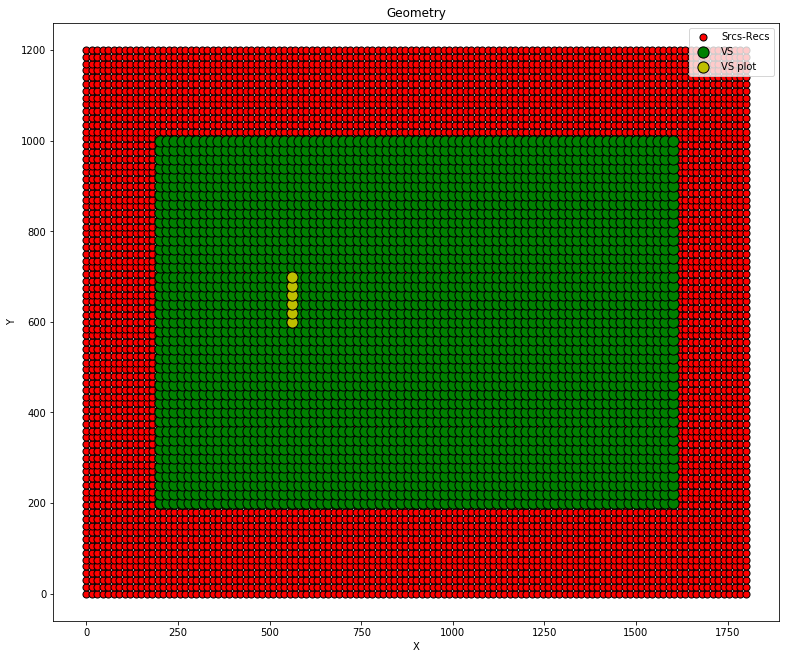

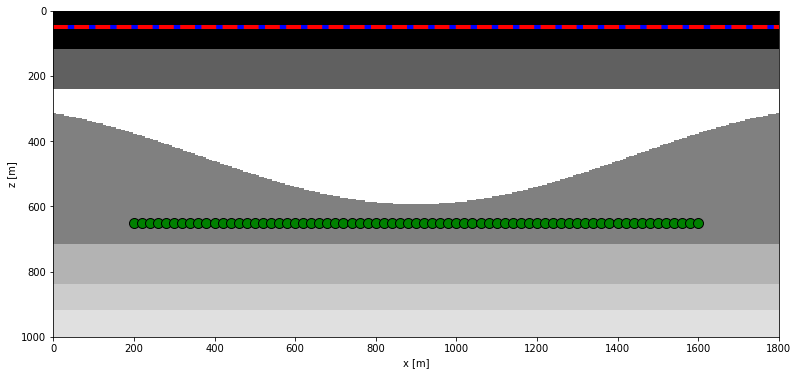

In [25]:
# Load input
inputdata_aux = np.load(inputfile_aux)

# Receivers
r = inputdata_aux['recs'][::subsampling].T
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata_aux['srcs'][::subsampling].T
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
ivsmdd = (ivsmdd_start + ivsmdd_end) // 2
vsz = 650
nvsx = 71
dvsx = 20
ovsx = 200
nvsy = 41
dvsy = 20
ovsy = 200
nvs = nvsx * nvsy
vsy = np.arange(nvsy) * dvsy + ovsy 
vsx = np.arange(nvsx) * dvsx + ovsx 
VSX, VSY = np.meshgrid(vsx, vsy, indexing='ij')

# Time axis
ot, dt, nt = 0, 2.5e-3, 601
t = np.arange(nt)*dt

# Density model
rho = inputdata_aux['rho']
z, x, y = inputdata_aux['z'], inputdata_aux['x'], inputdata_aux['y']

# Display geometry
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(13, 11))      
ax.scatter(r[0], r[1], marker='.', s=200, c='r', edgecolors='k', label='Srcs-Recs')
ax.scatter(VSX.ravel(), VSY.ravel(), marker='.', s=500, c='g', edgecolors='k', label='VS')
ax.scatter(VSX.ravel()[ivsmdd_start:ivsmdd_end+1], 
           VSY.ravel()[ivsmdd_start:ivsmdd_end+1], marker='.', s=500, 
           c='y', edgecolors='k', label='VS plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Geometry')
plt.legend()
plt.show()

fig, ax1 = plt.subplots(1, 1, figsize=(13, 6))
ax1.imshow(rho[np.argmin(np.abs(y-VSY.ravel()[ivsmdd_start]))].T, cmap='gray', vmin=1000, vmax=5000,
           extent = (x[0], x[-1], z[-1], z[0]))
ax1.axhline(r[2, 0], color='b', lw=4)
ax1.axhline(s[2, 0], color='r', linestyle='--', lw=4)
ax1.scatter(vsx, vsz * np.ones(nvsx), marker='.', s=400, c='g', edgecolors='k')
ax1.axis('tight')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('z [m]')
ax1.set_xlim(x[0], x[-1]);

Read data

In [26]:
if kind == 'Mck':
    Gplus = da.from_zarr(os.environ["STORE_PATH"] + 'Gplus_sub%d.zarr' % subsampling)
    Gminus = da.from_zarr(os.environ["STORE_PATH"] + 'Gminus_sub%d.zarr' % subsampling)
else:
    Gplus = da.from_zarr(os.environ["STORE_PATH"] + 'Gdir_sub%d.zarr' % subsampling)
    Gminus = da.from_zarr(os.environ["STORE_PATH"] + 'Grtm_sub%d.zarr' % subsampling)

In [27]:
Gplus

,Array,Chunk
Bytes,68.59 GB,23.56 MB
Shape,"(601, 9801, 2911)","(601, 9801, 1)"
Count,2912 Tasks,2911 Chunks
Type,float32,numpy.ndarray


Pad data at negative times and choose single VS

In [28]:
nvs_inv = ivsmdd_end - ivsmdd_start + 1 # number of virtual points inverted simultaneously 
Gminus = Gminus[:, :, ivsmdd_start:ivsmdd_end+1]
Gminus = da.concatenate((da.zeros((nt-1, nr, nvs_inv), dtype=np.float32), Gminus), axis=0)

Gminus = client.persist(Gminus)

In [29]:
Gminus

dask.array<concatenate, shape=(1201, 9801, 6), dtype=float32, chunksize=(601, 9320, 1), chunktype=numpy.ndarray>

Prepare MDC kernel

In [30]:
nchunks_in = [nt, nr, nvs // nworkers]
nchunks = [max(nfmax // (nworkers + 1), 1), nr, nvs]

# Works best when Gplus is not chunked only along vs axis
#Gplus = da.concatenate((da.zeros((nt-1, nr, nvs)), Gplus), axis=0)
#Gplus = Gplus.rechunk(2*nt-1, Gplus.chunks[1][0], Gplus.chunks[2][0])
#Gplus = da.fft.rfft(Gplus, 2*nt-1, axis=0)
#Gplus = Gplus[:nfmax]
#Gplus = Gplus.rechunk(nchunks)
#Gplus = client.persist(Gplus)  
#client.rebalance(Gplus)

# Works best when Gplus is chunked only along vs axis
Gplus = Gplus.rechunk(nchunks_in)
Gplus = da.concatenate((da.zeros((nt-1, nr, nvs), dtype=np.float32), Gplus), axis=0)
Gplus = Gplus.rechunk([2*nt-1, nchunks_in[1], nchunks_in[2]])
Gplus = da.fft.rfft(Gplus, 2*nt-1, axis=0)
Gplus = Gplus[:nfmax]
Gplus = Gplus.rechunk(nchunks)
Gplus = client.persist(Gplus)  
client.rebalance(Gplus)

In [ ]:
Gplus

Define modelling operator

In [31]:
Gplusop = \
    pylops_distributed.waveeqprocessing.MDC(Gplus, nt=2*nt-1, 
                                            nv=nvs_inv, dt=dt, 
                                            dr=dvsx*dvsy, 
                                            prescaled=True,
                                            twosided=True)
ddottest(Gplusop, (2*nt-1)*nr*nvs_inv, (2*nt-1)*nvs*nvs_inv,  
         chunks=(Gplusop.shape[0], Gplusop.shape[1]),
         complexflag=3, verb=True);

Dot test passed, v^T(Opu)=-152149.863685 - u^T(Op^Tv)=-152149.863685


Compute adjoint and inverse

In [32]:
Radj = Gplusop.H * Gminus.ravel()
Radj = Radj.reshape(2*nt-1, nvs, nvs_inv)
Radj = Radj.compute()

In [33]:
Rinv = dcgls(Gplusop, Gminus.ravel(), niter=10, compute=False)[0]
Rinv = Rinv.reshape(2*nt-1, nvs, nvs_inv)
Rinv = Rinv.compute()

(0.4, -0.4)

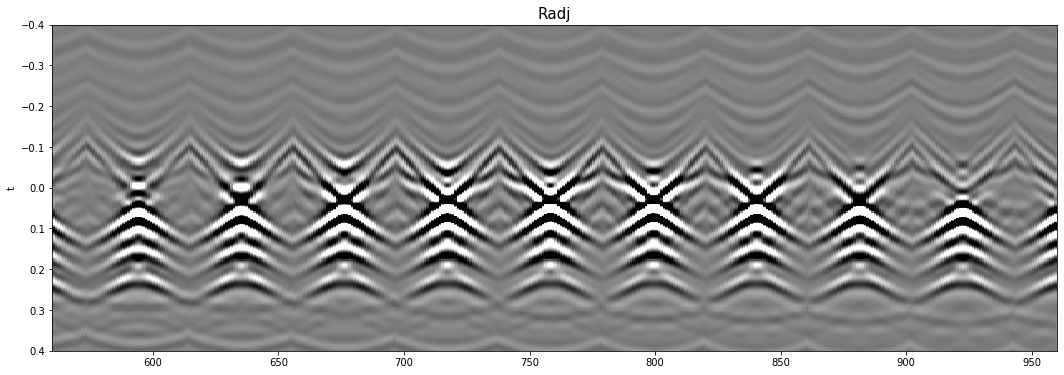

In [34]:
fig, ax1 = plt.subplots(1, 1, figsize=(18, 6))
ax1.imshow(Radj[:, :, 0], aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-0.05*Radj.max(), vmax=0.05*Radj.max(),
           extent=(0, nvs, t.max(), -t.max()))
ax1.set_title('Radj', fontsize=15)
ax1.set_ylabel('t')
ax1.set_xlim(ivsmdd-200, ivsmdd+200);
ax1.set_ylim(0.4, -0.4)

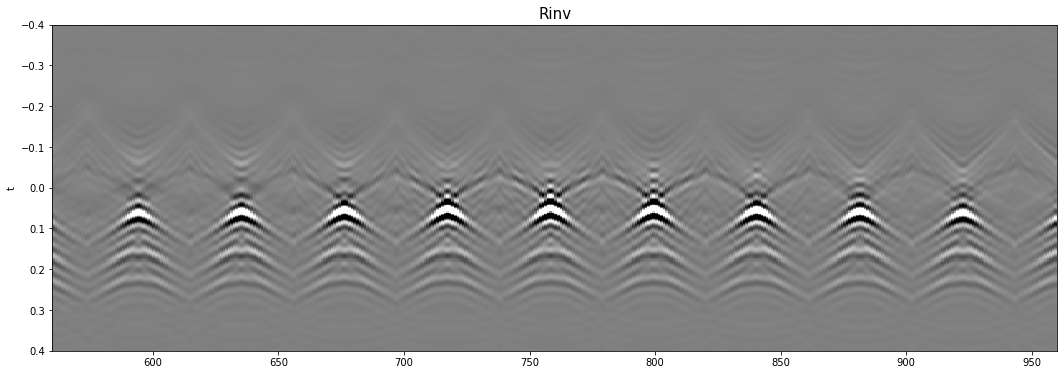

In [35]:
fig, ax1 = plt.subplots(1, 1, figsize=(18, 6))
ax1.imshow(Rinv[:, :, 0], aspect='auto',interpolation='nearest', cmap='gray', 
           vmin=-0.2*Rinv.max(), vmax=0.2*Rinv.max(),
           extent=(0, nvs, t.max(), -t.max()))
ax1.set_title('Rinv', fontsize=15)
ax1.set_ylabel('t')
ax1.set_xlim(ivsmdd-200, ivsmdd+200);
ax1.set_ylim(0.4, -0.4);

In [36]:
client.close()

In [37]:
cluster.close()